<a href="https://colab.research.google.com/github/matsudayuko/LectureNotes/blob/master/Gensim_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Gensim LDA

Topic Modeling with Gensim <br>
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages

In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, LdaMulticore

https://radimrehurek.com/gensim/models/ldamulticore.html

In [ ]:
from gensim.test.utils import common_corpus, common_dictionary
lda = LdaMulticore(common_corpus, num_topics=10)

In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

In [ ]:
lda = LdaModel.load(temp_file)

In [ ]:
other_texts = [
    ['computer', 'time', 'graph'],
    ['survey', 'response', 'eps'],
    ['human', 'system', 'computer']
]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
vector = lda[unseen_doc]  # get topic probability distribution for a document

# Update the model by incrementally training on the new corpus.
lda.update(other_corpus)  

### Topic Model Paper
- Applications of Topic Models https://mimno.infosci.cornell.edu/papers/2017_fntir_tm_applications.pdf
- ALTO: Active Learning with Topic Overviews for Speeding Label
Induction and Document Labeling https://home.cs.colorado.edu/~jbg/docs/2016_acl_doclabel.pdf
- Topically Driven Neural Language Model https://arxiv.org/abs/1704.08012
- 階層的トピックモデルに基づく宿泊レビューの時間変化分析 https://must.c.u-tokyo.ac.jp/sigam/sigam23/sigam2305.pdf
- 文書の階層構造を考慮したバイリンガルトピックモデル https://www.anlp.jp/proceedings/annual_meeting/2016/pdf_dir/P18-3.pdf

## Gensim Topic Modeling

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages

2. Prerequisites – Download nltk stopwords and spacy model

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Run in terminal or command prompt
!pip install -U pip setuptools wheel
!pip install -U spacy

In [ ]:
!python -m spacy download en_core_web_sm

2021-02-11 11:55:28.278293: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
     |████████████████████████████████| 13.7 MB 5.3 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


3. Import Packages

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 4.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.0-py2.py3-none-any.whl size=136694 sha256=2b8e9718f7c25cbdc932373a2b0e516d59d5ce698663e98f548d3d0940eb5adc
  Stored in directory: /root/.cache/pip/wheels/5e/62/9d/e2d11b7e09f85508b7be451fa35a2bce4b12c66c10b8bcb182
Successfully built pyLDAvis


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

5. Prepare Stopwords

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

6. Import Newsgroups Data

In [ ]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


7. Remove emails and newline characters

In [ ]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


8. Tokenize words and Clean-up text

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


9. Creating Bigram and Trigram Models

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


10. Remove Stopwords, Make Bigrams and Lemmatize

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'umd', 'organization', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'saw', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


11. Create the Dictionary and Corpus needed for Topic Modeling

In [ ]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 5), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]]


In [ ]:
id2word[0]

'addition'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('saw', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

12. Building the Topic Model

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
lda_model.save(temp_file)

In [ ]:
from gensim.models import LdaModel
lda_model = LdaModel.load(temp_file)

13. View the topics in LDA model

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"max" + 0.033*"internet" + 0.016*"family" + 0.012*"mr" + 0.010*"sc" + '
  '0.010*"club" + 0.010*"fbi" + 0.010*"rational" + 0.010*"_" + 0.009*"ai"'),
 (1,
  '0.016*"thus" + 0.016*"existence" + 0.016*"sin" + 0.015*"steven" + '
  '0.015*"new_york" + 0.014*"author" + 0.012*"period" + 0.012*"headache" + '
  '0.011*"proof" + 0.010*"islam"'),
 (2,
  '0.026*"do" + 0.021*"write" + 0.017*"know" + 0.016*"get" + 0.015*"make" + '
  '0.015*"think" + 0.014*"go" + 0.014*"say" + 0.012*"time" + 0.012*"see"'),
 (3,
  '0.014*"state" + 0.012*"israel" + 0.012*"people" + 0.010*"law" + '
  '0.008*"issue" + 0.008*"government" + 0.007*"right" + 0.007*"israeli" + '
  '0.006*"patient" + 0.006*"american"'),
 (4,
  '0.082*"_" + 0.026*"physical" + 0.014*"pa" + 0.012*"cx" + 0.011*"direct" + '
  '0.010*"mc" + 0.008*"diagnosis" + 0.008*"gay" + 0.007*"food" + 0.007*"eeg"'),
 (5,
  '0.019*"season" + 0.015*"goal" + 0.015*"nhl" + 0.014*"wing" + 0.014*"scott" '
  '+ 0.011*"pen" + 0.010*"syndrome" + 0.009*"van"

14. Compute Model Perplexity and Coherence Score

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.76668715591179

Coherence Score:  0.5314347094260359


15. Visualize the topics-keywords

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.277172 -0.100450       1        1  24.400223
8      0.194110  0.122725       2        1  10.915185
3      0.161314 -0.191372       3        1   7.461160
15     0.176225 -0.209461       4        1   6.318990
14     0.108483  0.208441       5        1   5.975323
7      0.107920  0.217685       6        1   5.331427
19     0.105849  0.141053       7        1   4.932568
18    -0.169970 -0.009880       8        1   4.844584
6      0.097257  0.068934       9        1   3.808862
10     0.000193 -0.067742      10        1   3.693222
12     0.033730 -0.190643      11        1   3.297478
9      0.009075  0.066743      12        1   3.100230
11    -0.045698 -0.058484      13        1   2.765133
17    -0.073101  0.027159      14        1   2.710856
16    -0.078868  0.059679      15        1   2.497995
5     -0.134960 -0.030214      16        1   1.779071
4     -0.210408 -0.010473      17        1   1.605311
1     -0.133109 -0.041664      18        1   1.569375
13    -0.209695 -0.004141      19        1   1.507507
0     -0.215519  0.002106      20        1   1.485502, topic_info=              Term          Freq         Total Category  logprob  loglift
5422            ax  41415.000000  41415.000000  Default  30.0000  30.0000
26    organization  11983.000000  11983.000000  Default  29.0000  29.0000
18            line  13092.000000  13092.000000  Default  28.0000  28.0000
59              do  10158.000000  10158.000000  Default  27.0000  27.0000
25      nntp_poste   5002.000000   5002.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
4144         adobe     85.450552     86.451720  Topic20  -5.5856   4.1978
1257            sc    236.907076    305.802469  Topic20  -4.5659   3.9541
2878            mo    124.322090    149.512220  Topic20  -5.2107   4.0249
3143            mr    268.425786    678.040467  Topic20  -4.4410   3.2828
1086             _    219.615370   2240.167324  Topic20  -4.6417   1.8870

[990 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1086      17  0.901718           _
1086      20  0.098207           _
6647       5  0.141219  absolutely
6647      18  0.855873  absolutely
1589       3  0.752998      accept
...      ...       ...         ...
45        11  0.033617        year
45        12  0.043422        year
12330     19  0.985729          zd
6714       6  0.995825         zip
2608      14  0.995674        zone

[1591 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 9, 4, 16, 15, 8, 20, 19, 7, 11, 13, 10, 12, 18, 17, 6, 5, 2, 14, 1])

16. Building LDA Mallet Model

In [ ]:
!wget https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2021-02-11 12:23:14--  https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip
Resolving www.machinelearningplus.com (www.machinelearningplus.com)... 104.21.82.62, 172.67.197.110, 2606:4700:3030::ac43:c56e, ...
Connecting to www.machinelearningplus.com (www.machinelearningplus.com)|104.21.82.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip        [               <=>  ]  16.25M  3.98MB/s    in 4.1s    

2021-02-11 12:23:22 (3.98 MB/s) - ‘mallet-2.0.8.zip’ saved [17038940]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
  inflating: mallet-2.0.8/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/mallet-2.0.8/
  inflating: __MACOSX/mallet-2.0.8/._.DS_Store  
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
   creating: __MACOSX/mallet-2.0.8/bin/
  inflating: __MACOSX/mallet-2.0.8/bin/._classifier2info  
  inflating: 

In [ ]:
!ls mallet-2.0.8

bin	   class  lib	   Makefile  README.md	  src	     test
build.xml  dist   LICENSE  pom.xml   sample-data  stoplists


In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

[(13,
  [('line', 0.11115830115830116),
   ('organization', 0.1093050193050193),
   ('university', 0.08976833976833977),
   ('nntp_poste', 0.08532818532818533),
   ('host', 0.07907335907335908),
   ('reply', 0.02193050193050193),
   ('usa', 0.012007722007722007),
   ('keyword', 0.010154440154440154),
   ('david', 0.007876447876447876),
   ('dept', 0.007760617760617761)]),
 (14,
  [('key', 0.031888044005824304),
   ('system', 0.014172464002588578),
   ('encryption', 0.011502993043196894),
   ('bit', 0.010370490211939816),
   ('technology', 0.009739524348810872),
   ('security', 0.009626274065685165),
   ('chip', 0.008946772366930917),
   ('government', 0.008768807636304806),
   ('public', 0.008574664293803592),
   ('privacy', 0.006746481151917166)]),
 (6,
  [('_', 0.030079179015349226),
   ('period', 0.005861016499314371),
   ('goal', 0.004600345025876941),
   ('van', 0.004423408678727828),
   ('canada', 0.0043349405051532714),
   ('mc', 0.004202238244791436),
   ('flyer', 0.00395895076

In [ ]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6411459762857621


17. How to find the optimal number of topics for LDA?

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

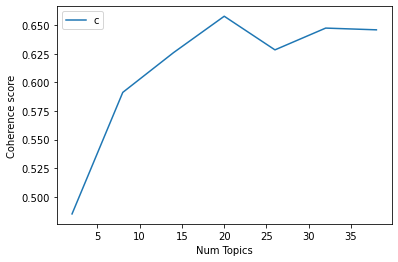

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.485
Num Topics = 8  has Coherence Value of 0.5913
Num Topics = 14  has Coherence Value of 0.6261
Num Topics = 20  has Coherence Value of 0.6579
Num Topics = 26  has Coherence Value of 0.6285
Num Topics = 32  has Coherence Value of 0.6476
Num Topics = 38  has Coherence Value of 0.646


In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.015*"line" + 0.012*"power" + 0.010*"work" + 0.008*"ground" + '
  '0.007*"water" + 0.007*"current" + 0.007*"wire" + 0.006*"light" + '
  '0.005*"organization" + 0.005*"high"'),
 (1,
  '0.030*"car" + 0.012*"article" + 0.012*"bike" + 0.011*"line" + 0.010*"buy" + '
  '0.010*"organization" + 0.010*"write" + 0.008*"ride" + 0.007*"drive" + '
  '0.007*"good"'),
 (2,
  '0.012*"work" + 0.012*"year" + 0.011*"make" + 0.009*"president" + '
  '0.009*"money" + 0.008*"pay" + 0.008*"government" + 0.007*"people" + '
  '0.007*"national" + 0.007*"job"'),
 (3,
  '0.024*"space" + 0.008*"system" + 0.007*"launch" + 0.007*"research" + '
  '0.007*"center" + 0.007*"nasa" + 0.007*"earth" + 0.006*"project" + '
  '0.006*"science" + 0.006*"satellite"'),
 (4,
  '0.029*"key" + 0.016*"system" + 0.010*"encryption" + 0.010*"message" + '
  '0.009*"information" + 0.009*"bit" + 0.008*"security" + 0.008*"chip" + '
  '0.007*"technology" + 0.007*"public"'),
 (5,
  '0.049*"line" + 0.041*"organization" + 0.036*"window" 

18. Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.1624,"car, article, bike, line, buy, organization, w...",From: (wheres my thing) Subject: WHAT car is t...
1,1,15.0,0.1980,"drive, system, bit, scsi, card, mac, disk, mac...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,16.0,0.1690,"thing, make, good, people, time, ve, point, ba...",From: (Thomas E Willis) Subject: PB questions....
3,3,5.0,0.1038,"line, organization, window, problem, universit...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,3.0,0.1234,"space, system, launch, research, center, nasa,...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,17.0,0.4513,"gun, state, law, people, case, crime, weapon, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,10.0,0.1105,"study, drug, science, article, food, effect, d...",From: (brian manning delaney) Subject: Brain T...
7,7,15.0,0.5873,"drive, system, bit, scsi, card, mac, disk, mac...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,5.0,0.1911,"line, organization, window, problem, universit...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,15.0,0.2496,"drive, system, bit, scsi, card, mac, disk, mac...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


19. Find the most representative document for each topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7816,"line, power, work, ground, water, current, wir...","From: Subject: Grounding power wiring, was Re:..."
1,1.0,0.6279,"car, article, bike, line, buy, organization, w...",From: (DEMOSTHENIS A. ZEPPOS) Subject: Re: Int...
2,2.0,0.8467,"work, year, make, president, money, pay, gover...",From: (Clinton/Gore 92) Subject: CLINTON: Back...
3,3.0,0.8243,"space, system, launch, research, center, nasa,...",From: (Jon Leech) Subject: Space FAQ 11/15 - U...
4,4.0,0.9046,"key, system, encryption, message, information,...",From: (Jim Gillogly) Subject: Clipper Chip and...


20. Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"car, article, bike, line, buy, organization, w...",561.0,0.0496
1.0,15.0,"drive, system, bit, scsi, card, mac, disk, mac...",1016.0,0.0898
2.0,16.0,"thing, make, good, people, time, ve, point, ba...",288.0,0.0255
3.0,5.0,"line, organization, window, problem, universit...",577.0,0.0510
4.0,3.0,"space, system, launch, research, center, nasa,...",532.0,0.0470
...,...,...,...,...
11309.0,10.0,"study, drug, science, article, food, effect, d...",NaN,NaN
11310.0,0.0,"line, power, work, ground, water, current, wir...",NaN,NaN
11311.0,15.0,"drive, system, bit, scsi, card, mac, disk, mac...",NaN,NaN
11312.0,3.0,"space, system, launch, research, center, nasa,...",NaN,NaN


### LDA+GPU並列化（古い）

https://www.jstage.jst.go.jp/article/itetr/32.54/0/32.54_1/_pdf/-char/ja　<br>
https://tsubosaka.hatenadiary.org/entry/20091129/1259501998

## 隠れマルコフモデル

### 隠れマルコフモデルを用いた異常検知

https://qiita.com/DS27/items/55a90c9791347d7622e5

データ http://www.cs.ucr.edu/~eamonn/discords/

In [ ]:
!wget http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt

--2021-02-11 11:08:52--  http://www.cs.ucr.edu/~eamonn/discords/qtdbsel102.txt
Resolving www.cs.ucr.edu (www.cs.ucr.edu)... 169.235.30.15
Connecting to www.cs.ucr.edu (www.cs.ucr.edu)|169.235.30.15|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125000 (1.1M) [text/plain]
Saving to: ‘qtdbsel102.txt.1’

qtdbsel102.txt.1    100%[===================>]   1.07M  2.62MB/s    in 0.4s    

2021-02-11 11:08:54 (2.62 MB/s) - ‘qtdbsel102.txt.1’ saved [1125000/1125000]



プログラム

hmmlearn <br>
https://hmmlearn.readthedocs.io/en/latest/

In [ ]:
!pip install --upgrade hmmlearn

     |████████████████████████████████| 368kB 5.6MB/s 


Text(0.5, 0, 'time')

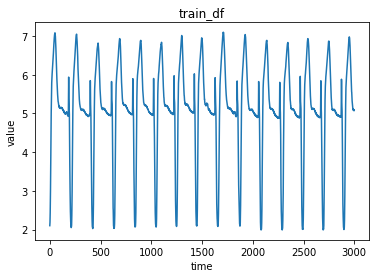

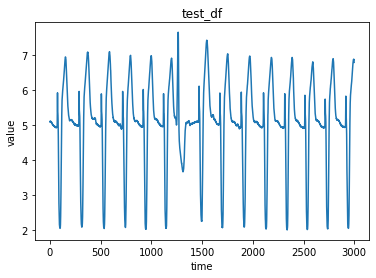

In [ ]:
# 必要なライブラリーのインポート
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 必要な関数を読み込む
from hmmlearn import hmm

df = np.loadtxt("qtdbsel102.txt", delimiter="\t")
# 3列目のデータを使用
# trainデータ, testデータを作成
train_df = df[0:3000, 2]
test_df = df[3000:6000, 2]

# 学習データの可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(False)

ax.plot(train_df)

ax.set_title('train_df')
ax.set_ylabel('value')
ax.set_xlabel('time')

# 評価データの可視化
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.grid(False)

ax.plot(test_df)

ax.set_title('test_df')
ax.set_ylabel('value')
ax.set_xlabel('time')

In [ ]:
num_states = 15

X = train_df.reshape(-1, 1)
lengths = [len(train_df)]

np.random.seed(seed=7)
model = hmm.GaussianHMM(n_components=num_states, covariance_type='full')
model.fit(X, lengths)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=15, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
# model.scores()関数では、系列x'の対数尤度p(log(x'))が計算される。
logprob = np.array([model.score(train_df[0:i+1].reshape(-1, 1)) for i in range(len(train_df))])
train_abnormality = -np.append(logprob[0], np.diff(logprob))

# 閾値の設定
ratio = 0.005 # 異常と判断する割合
threshold = np.sort(train_abnormality)[int((1-ratio)*len(train_abnormality))]
print(threshold)

3.1943835235051665


Text(0, 0.5, 'test_df_abnormality')

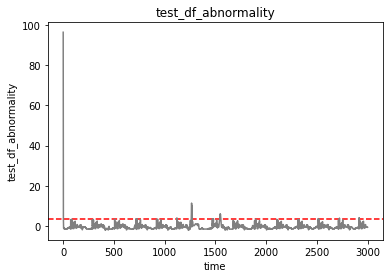

In [ ]:
# 評価データの異常検知
logprob = np.array([model.score(test_df[0:i+1].reshape(-1, 1)) for i in range(len(test_df))])
test_abnormality = -np.append(logprob[0], np.diff(logprob))

# 評価データの異常度を可視化
# 管理限界を破線で示す
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(False)

ax.axhline(threshold, ls="--", color="red")
ax.plot(test_abnormality, color="gray")

ax.set_title('test_df_abnormality')
ax.set_xlabel('time')
ax.set_ylabel('test_df_abnormality')

Text(0, 0.5, 'abnormality')

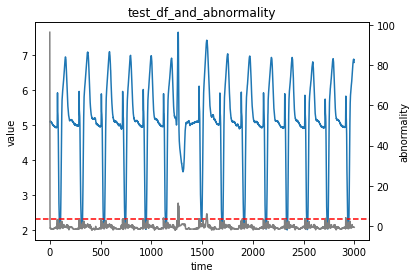

In [ ]:
# 評価データの異常度を可視化
# 管理限界を破線で示す
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.grid(False)

# ax1とax2を関連させる
ax2 = ax1.twinx()

ax2.axhline(threshold, ls="--", color="red")
ax1.plot(test_df)
ax2.plot(test_abnormality, color="gray")

ax1.set_title('test_df_and_abnormality')
ax1.set_ylabel('value')
ax1.set_xlabel('time')
ax2.set_ylabel('abnormality')

### 隠れマルコフモデルを実現するPythonライブラリ hmmlearnの使い方

https://qiita.com/tags/%e9%9a%a0%e3%82%8c%e3%83%9e%e3%83%ab%e3%82%b3%e3%83%95%e3%83%a2%e3%83%87%e3%83%ab

必要なパラメータ

In [ ]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=3, covariance_type="full")

~~~
引数のn_componetsは状態数を指定して、covariance_typeは共分散の種類を指定します。

指定が必須となる属性は以下となります。

startprob_
初期状態の遷移確率を指定します。(状態数 * 1)
transmat_
状態遷移確率を指定します。(状態数 * 状態数)
means_
各状態の平均を指定します。(状態数 * 特徴数)
covars_
共分散を指定します。(covariance_typeによる)
今回は例で状態数を５個としてパラメータを入れました。
~~~

In [ ]:
import numpy as np
from hmmlearn import hmm


startprob = np.array([0.0, 0.1, 0.8, 0.1, 0.0])
transmat = np.array([[0.9, 0.1, 0.0, 0.0, 0.0],
                     [0.4, 0.3, 0.3, 0.0, 0.0],
                     [0.1, 0.2, 0.4, 0.3, 0.0],
                     [0.0, 0.1, 0.3, 0.3, 0.3],
                     [0.0, 0.0, 0.3, 0.1, 0.6]])

means = np.array([[1.0, 1.0],
                  [2.0, 2.0],
                  [3.0, 3.0],
                  [4.0, 4.0],
                  [5.0, 5.0]])

covars = 0.1 * np.tile(np.identity(2), (5, 1, 1))

model = hmm.GaussianHMM(n_components=5, covariance_type="full")

model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = covars

予測

In [ ]:
X, Z = model.sample(10)

print(X)

print(Z)

[[2.75052063 3.00065319]
 [2.6406052  1.99958003]
 [2.80222199 2.94575168]
 [1.99526664 2.00676433]
 [2.17537369 2.03917458]
 [1.27634949 1.03275296]
 [1.52199708 1.04880518]
 [0.54611008 0.9504096 ]
 [0.8718557  0.27637123]
 [1.15084564 1.18974104]]
[2 1 2 1 1 0 0 0 0 0]


In [ ]:
model.predict([[1.3], [2.0], [4.3], [4.2]])

array([1, 2, 3, 3])

学習

In [ ]:
import numpy as np
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=5, covariance_type="full")
X = np.array([[1.2], [2.3], [1.1], [4.2], [3.3]])
model.fit(X)

Fitting a model with 34 free scalar parameters with only 5 data points will result in a degenerate solution.


GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=5, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
model.startprob_

array([9.96868150e-001, 0.00000000e+000, 2.06946712e-292, 1.27702612e-300,
       3.13184994e-003])

In [ ]:
model.means_

array([[1.15485602],
       [4.2       ],
       [2.3       ],
       [3.3       ],
       [1.10171369]])

In [ ]:
model.covars_

array([[[0.00797925]],

       [[0.01      ]],

       [[0.01      ]],

       [[0.01      ]],

       [[0.05488646]]])

In [ ]:
model.transmat_

array([[0.00000000e+000, 4.51439835e-001, 5.48560165e-001,
        6.49028218e-045, 1.32144625e-190],
       [5.18696363e-119, 2.07494122e-025, 5.88225536e-075,
        1.00000000e+000, 1.88590294e-063],
       [8.20376728e-001, 1.57268167e-192, 1.27206138e-223,
        9.10036066e-211, 1.79623272e-001],
       [1.50081312e-010, 2.06495338e-025, 1.79414943e-074,
        1.00000000e+000, 3.28132831e-011],
       [3.48719264e-293, 9.82863134e-001, 1.71368655e-002,
        9.25847733e-045, 6.65061859e-190]])

評価

In [ ]:
X = np.array([[3.2], [2.4], [3.1], [3.2], [3.0], [3.9], [4.0]])
model.score(X)
#0.11878179338435844

-177.5687256731581

書き出しと読み込み

In [ ]:
from sklearn.externals import joblib
joblib.dump(model, "filename.pkl")

['filename.pkl']

In [ ]:
from sklearn.externals import joblib
joblib.load('filename.pkl')

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=5, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

HMMを利用した深層学習ネットワークからの分類パターンの
抽出と可視化 <br>
https://must.c.u-tokyo.ac.jp/sigam/sigam23/sigam2308.pdf